### **DATASET OVERVIEW**

Dataset source: [**Link**](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data)  
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### **IMPORT LIBRARIES**

In [126]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec, FastText
import gensim.downloader as api

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
nltk.download('punkt', quiet = True)
nltk.download('stopwords', quiet = True)

True

> Here, I've imported the neccessary libraries for the whole process of reading data to performing sentiment analysis.

### **READ DATA**

In [3]:
data = pd.read_csv("./Dataset/Tweets.csv")

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


> Based on the output above, the data has been successfully read.

### **EDA AND PREPROCESSING**

#### **DATA EXPLORATION**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

> The data conssists of 14640 observations and 15 columns.  
> However, since I'm aiming to perform a sentiment analysis on the tweet, I'm keeping only the **text** section and the **airline_sentiment** (target).
> The main reason is to avoid the model from capturing spurious correlations.  
> For example, if I keep **retweet_count**, the model may miscalculate it with "the more retweet the tweet have, the more positive the tweet is", but in fact, people can retweet both positive and negative tweets.

In [6]:
data = data[["text", "airline_sentiment"]]

In [7]:
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


#### **DUPLICATES**

In [8]:
data.duplicated().sum()

188

> From the 14640 observations in the data, there are 188 duplicated entries, so I will be dropping them to ensure that the model does not become overly influenced by repeated samples, which could lead to overfitting rather than genuine generalization.

In [9]:
data = data.drop_duplicates().reset_index(drop=True)

In [10]:
data.duplicated().sum()

0

> After removing duplicate observations, I check for identical texts assigned to different sentiment labels, as such inconsistencies may confuse the model during training.

In [11]:
data["text"].duplicated().sum()

25

In [12]:
duplicates = data[data['text'].duplicated(keep = False)].sort_values('text')

display(duplicates)

,text,airline_sentiment
12005,@AmericanAir - keeping AA up in the Air! My cr...,positive
11919,@AmericanAir - keeping AA up in the Air! My cr...,neutral
11926,@AmericanAir @Clarkey_19 we done it with 1 tru...,neutral
12006,@AmericanAir @Clarkey_19 we done it with 1 tru...,positive
12002,@AmericanAir @RobertDwyer AA doesnt charge any...,neutral
11896,@AmericanAir @RobertDwyer AA doesnt charge any...,positive
11997,"@AmericanAir Believe me, I understand. Flight ...",negative
11843,"@AmericanAir Believe me, I understand. Flight ...",positive
12000,@AmericanAir I don't think you should help him...,neutral
11876,@AmericanAir I don't think you should help him...,positive


In [13]:
data = data.drop_duplicates(subset = 'text', keep = False)

In [14]:
data["text"].duplicated().sum()

0

> Here, I have removed all duplicates and identical texts with conflicting sentiment labels to ensure data consistency before proceeding to the next step.

#### **CARDINALITY CHECK**

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14402 entries, 0 to 14451
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14402 non-null  object
 1   airline_sentiment  14402 non-null  object
dtypes: object(2)
memory usage: 337.5+ KB


In [16]:
cardinal = pd.DataFrame({
    "column name": data.columns.tolist(),
    "data type": [data[c].dtype for c in data.columns],
    "unique values": [data[c].nunique() for c in data.columns]
})
print("Cardinality Check Result:")
cardinal

Cardinality Check Result:


,column name,data type,unique values
0,text,object,14402
1,airline_sentiment,object,3


> Here, I can infer that the texts inside the data are all unique with 3 different sentiments.  
> This confirms that no redundant textual data remain, ensuring a clean and unbiased foundation for sentiment classification.

#### **MISSING VALUES**

In [17]:
data.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

> The data has no missing observations.  
> Hence, further handling is unneccessary.

#### **DATA DISTRIBUTION**

In [18]:
print(data["airline_sentiment"].unique(), "\n")

['neutral' 'positive' 'negative'] 



> The data contains three sentiment classes: positive, neutral, and negative.

In [19]:
train_data, test_data = train_test_split(data, test_size = 0.2, stratify = data["airline_sentiment"], random_state = 42)
print(f"Train Shape: {train_data.shape}")
print(f"Test Shape: {test_data.shape}")

Train Shape: (11521, 2)
Test Shape: (2881, 2)


> Here, I perform a train-test split to prevent data leakage.

<Axes: xlabel='airline_sentiment', ylabel='count'>

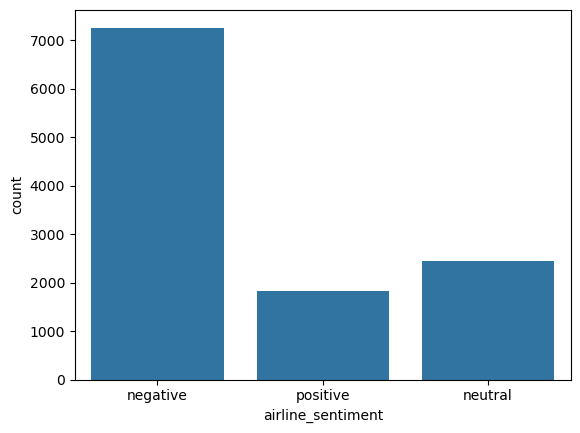

In [20]:
sns.countplot(x = "airline_sentiment", data = train_data)

> Based on the sentiment distribution above, it can be inferred that the data is highly imbalanced, with negative sentiment samples being roughly three to four times more frequent than the positive and neutral ones.  
> This imbalance may cause the model to favor the negative class.  
> Therefore, one of the main objectives of this notebook is to compare model performance before and after applying imbalance handling techniques.

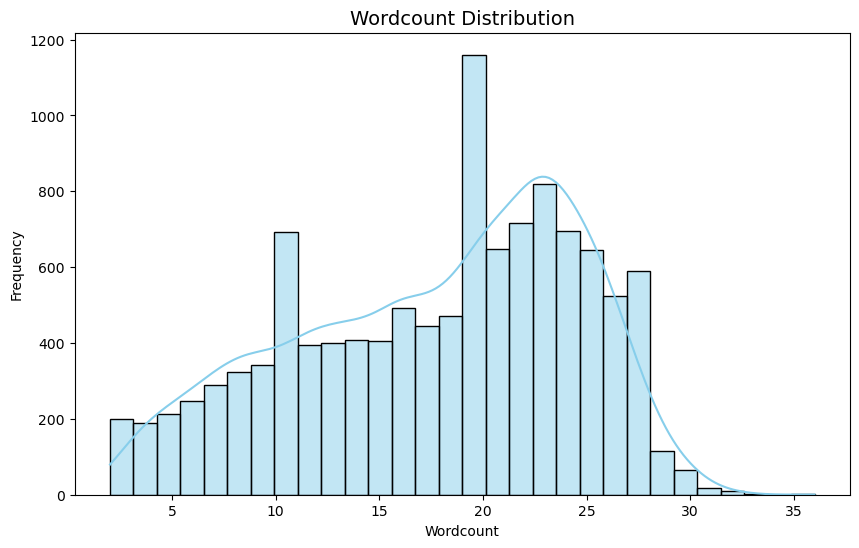

In [21]:
train_vis = train_data.copy()
train_vis["word_count"] = train_vis["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize = (10, 6))
sns.histplot(train_vis["word_count"], bins = 30, kde = True, color = "skyblue")

plt.title("Wordcount Distribution", fontsize = 14)
plt.xlabel("Wordcount")
plt.ylabel("Frequency")
plt.show()

> Here, I plotted the word count distribution of the data.  
> There are some entries with fewer than five words, and since one of them typically represents the airline's username, such samples may not be informative enough for the model to learn sentiment effectively.

In [22]:
short_sentences = train_vis[train_vis["word_count"] < 5]

print(f"Data with <5 words: {len(short_sentences)}")
display(short_sentences[["text", "word_count"]].head(20))

Data with <5 words: 387


,text,word_count
9692,@USAirways follow/dm please,3
7003,@JetBlue *fights air*,3
4809,"@SouthwestAir yes, please #companionpass",4
12685,@AmericanAir amen!,2
2829,@united exactly,2
8535,@JetBlue Aw okay thanks,4
370,@VirginAmerica delayed to10.30!!,3
8270,@JetBlue Just sent it,4
5657,@SouthwestAir I would.,3
1081,@united Definitely will!,3


> Here, I displayed several samples with fewer than five words.  
> As expected, these short texts do not convey any meaningful sentiment toward the airline, so I plan to remove them during preprocessing.

#### **PREPROCESSING**

In [23]:
for i, text in enumerate(train_data["text"].iloc[0:5], 1):
    print(f"{i}. {text}\n")

1. @JetBlue ruining vacations left and right. Who would have thought an airline can Cancelled Flight tickets without telling the buyer

2. @AmericanAir  upon entering plane to 2 @USAirways stewardesses: "can I have some water?" "no we don't do that. please take your seat"

3. @united Thank you for that. Am I able to claim any interim expenses or is the cost of the stuff up on me?

4. @AmericanAir Thanks! Bleh, disconnected! Let's try this again!!

5. @JetBlue 1472, FLL to LGA. This is getting old. 4th @JetBlue flight in 2.5 weeks, 4th significant delay.



In [24]:
for i, text in enumerate(train_data["text"].iloc[-6:-1], 1):
    print(f"{i}. {text}\n")

1. @united assistance with what, the attitude of your staff no matter which airport we are at?

2. @SouthwestAir your gate agent re-routed an impossible itinerary and we had to find a new airline to get us home. Super bummed about this

3. @SouthwestAir I did but it only shows one flight one way. When I try to go to the home page and book roundtrip there's nothing available :(

4. @VirginAmerica flight 404 delayed 2 hours in LA due to mechanical problems. Handle like pros but you could have tossed us a free drink.

5. @SouthwestAir what does relay concerns really mean &amp; how/why do u keep letting people on flights with bags larger than u state are allowabl?



> Here, I displayed several samples from the data to identify what kind of cleaning is required.  
> From these examples, I decided to remove the @Airline mentions, as they do not convey any sentiment information, and to remove punctuations since the objective is sentiment analysis rather than syntactic or question-based understanding.

In [25]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    s = str(text).lower()
    s = re.sub(r'@\w+', " ", s)
    s = re.sub(r'[^a-z\s]+', " ", s)
    s = re.sub(r'\s+', " ", s).strip()
    tokens = word_tokenize(s)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]

    return " ".join(tokens)

In [26]:
train_data_1 = train_data.copy()
train_data_1["text"] = train_data_1["text"].apply(preprocess_text)

train_data_1 = train_data_1[train_data_1["text"].str.split().str.len() >= 4]

In [27]:
test_data_1 = test_data.copy()
test_data_1["text"] = test_data_1["text"].apply(preprocess_text)

In [28]:
train_data_1.head()

,text,airline_sentiment
8356,ruining vacations left right would thought air...,negative
13186,upon entering plane stewardesses water please ...,negative
560,thank able claim interim expenses cost stuff,positive
12392,thanks bleh disconnected let try,negative
8438,fll lga getting old th flight weeks th signifi...,negative


In [29]:
def preprocess_text_2(text):
    s = str(text).lower()
    s = re.sub(r'@\w+', " ", s)
    s = re.sub(r'[^a-z\s]+', " ", s)
    s = re.sub(r'\s+', " ", s).strip()
    return s

> This second preprocessing function is used for Word2Vec, GloVe, and FastText models, as these embeddings can leverage stopwords to better capture sentence structure and contextual meaning.

In [30]:
train_data_2 = train_data.copy()
train_data_2["text"] = train_data_2["text"].apply(preprocess_text_2)

train_data_2 = train_data_2[train_data_2["text"].str.split().str.len() >= 4]

In [31]:
test_data_2 = test_data.copy()
test_data_2["text"] = test_data_2["text"].apply(preprocess_text)

In [32]:
train_data_2.head()

,text,airline_sentiment
8356,ruining vacations left and right who would hav...,negative
13186,upon entering plane to stewardesses can i have...,negative
560,thank you for that am i able to claim any inte...,positive
12392,thanks bleh disconnected let s try this again,negative
8438,fll to lga this is getting old th flight in we...,negative


> The data has been fully preprocessed and is now ready for vectorization and model training.

### **TEXT REPRESENTATION**

In [33]:
X_train_1 = train_data_1["text"]
y_train_1 = train_data_1["airline_sentiment"]
X_train_2 = train_data_2["text"].apply(lambda x: x.split())
y_train_2 = train_data_2["airline_sentiment"]

In [34]:
X_train_1.head()

8356     ruining vacations left right would thought air...
13186    upon entering plane stewardesses water please ...
560           thank able claim interim expenses cost stuff
12392                     thanks bleh disconnected let try
8438     fll lga getting old th flight weeks th signifi...
Name: text, dtype: object

In [35]:
X_train_2.head()

8356     [ruining, vacations, left, and, right, who, wo...
13186    [upon, entering, plane, to, stewardesses, can,...
560      [thank, you, for, that, am, i, able, to, claim...
12392    [thanks, bleh, disconnected, let, s, try, this...
8438     [fll, to, lga, this, is, getting, old, th, fli...
Name: text, dtype: object

In [36]:
X_test_1 = test_data_1["text"]
y_test_1 = test_data_1["airline_sentiment"]
X_test_2 = test_data_2["text"].apply(lambda x: x.split())
y_test_2 = test_data_2["airline_sentiment"]

> Here, I split the data into X (**text**) and y (the target variable, **airline_sentiment**).

#### **BAG OF WORDS (COUNTVECTORIZER)**

> The first vectorization method I used was the classic Bag of Words approach with CountVectorizer, which represents each tweet as a vector based on the frequency of its words.

In [37]:
bow = CountVectorizer(max_features = 7000)
X_train_BOW = bow.fit_transform(X_train_1)
X_test_BOW = bow.transform(X_test_1)
print("Count of uniques or vocabularies: ", len(bow.vocabulary_))
print("Example vocabularies: ", list(bow.vocabulary_.keys())[:10])
print("Example vector:", X_train_BOW[0].toarray()[0][:10])

Count of uniques or vocabularies:  7000
Example vocabularies:  ['ruining', 'vacations', 'left', 'right', 'would', 'thought', 'airline', 'cancelled', 'flight', 'tickets']
Example vector: [0 0 0 0 0 0 0 0 0 0]


#### **TF-IDF**

> The second vectorization method I applied was the TF-IDF Vectorizer, as it can better highlight important words by giving higher weights to terms that are frequent in a tweet but rare across the data.

In [38]:
tfidf = TfidfVectorizer(max_features = 7000, ngram_range=(1,2))
X_train_TFIDF = tfidf.fit_transform(X_train_1)
X_test_TFIDF = tfidf.transform(X_test_1)
print("Shape: ", X_train_TFIDF.shape)
print("Count of uniques or vocabularies: ", len(tfidf.vocabulary_))
print("Example vocabularies: ", list(tfidf.vocabulary_.keys())[:10])
print("Example vector:", X_train_TFIDF[0].toarray()[0][:10])

Shape:  (10338, 7000)
Count of uniques or vocabularies:  7000
Example vocabularies:  ['ruining', 'vacations', 'left', 'right', 'would', 'thought', 'airline', 'cancelled', 'flight', 'tickets']
Example vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### **WORD2VEC**

> Here, I used Word2Vec as the third vectorization method, since it can capture semantic relationships and similarities between words, unlike BoW or TF-IDF that rely solely on frequency.

In [39]:
print("Training W2V...")
w2v = Word2Vec(sentences = X_train_2, vector_size = 100, window = 7, min_count = 2, workers = 4)

Training W2V...


In [40]:
def average_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis = 0)

In [41]:
X_train_W2V = np.array([average_vector(t, w2v) for t in X_train_2])
X_test_W2V = np.array([average_vector(t, w2v) for t in X_test_2])
print("Shape: ", X_train_W2V.shape)
print("Count of uniques or vocabularies: ", len(w2v.wv))
print("Example vocabularies: ", list(w2v.wv.key_to_index.keys())[:10])
print("Example vector:", X_train_W2V[0][:10])

Shape:  (11110, 100)
Count of uniques or vocabularies:  5111
Example vocabularies:  ['to', 'i', 'the', 'a', 'you', 'for', 'flight', 'on', 'and', 't']
Example vector: [ 0.02360349  0.33995602  0.23368981 -0.15756534  0.017655   -0.7057472
  0.31090978  0.83498174 -0.34400615 -0.24324204]


#### **GLOVE**

> The fourth representation used is GloVe, another word embedding model similar to Word2Vec, but trained using global word co-occurrence statistics instead of local context prediction.  
> I also used the pretrained **glove-twitter-100** embeddings from Gensim, which were trained and better match the domain of my data.

In [42]:
glove = api.load("glove-twitter-100")

In [43]:
def get_vector(tokens):
    words = [w for w in tokens if w in glove]
    if not words:
        return np.zeros(glove.vector_size)
    return np.mean([glove[w] for w in words], axis = 0)

In [44]:
X_train_glove = np.array([get_vector(t) for t in X_train_2])
X_test_glove = np.array([get_vector(t) for t in X_test_2])
print("Shape: ", X_train_glove.shape)
print("Count of uniques or vocabularies: ", len(glove.key_to_index))
print("Example vocabularies: ", list(glove.key_to_index.keys())[:10])
print("Example vector:", X_train_glove[0][:10])

Shape:  (11110, 100)
Count of uniques or vocabularies:  1193514
Example vocabularies:  ['<user>', '.', ':', 'rt', ',', '<repeat>', '<hashtag>', '<number>', '<url>', '!']
Example vector: [ 0.05308282  0.22147179  0.1539059   0.01443494 -0.03866816 -0.00721848
  0.10360511  0.04060584  0.0597218  -0.05518379]


#### **FASTTEXT**

> The last representation I used is FastText, an improved embedding method compared to Word2Vec and GloVe, as it can generate representations for out-of-vocabulary (OOV) words by learning from subword information.  
> I used the pretrained **fasttext-wiki-news-subwords-300** embeddings, which already capture general English semantics while remaining flexible enough to adapt to noisy tweet data.

In [45]:
ftext = api.load("fasttext-wiki-news-subwords-300")

In [46]:
def average_vector_f(tokens, model):
    vectors = []
    for word in tokens:
        try:
            vectors.append(model[word])
        except KeyError:
            continue
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [47]:
X_train_FT = np.array([average_vector_f(t, ftext) for t in X_train_2])
X_test_FT = np.array([average_vector_f(t, ftext) for t in X_test_2])
print("Shape: ", X_train_FT.shape)
print("Count of uniques or vocabularies: ", len(ftext))
print("Example vocabularies: ", list(ftext.key_to_index.keys())[:10])
print("Example vector:", X_train_glove[0][:10])

Shape:  (11110, 300)
Count of uniques or vocabularies:  999999
Example vocabularies:  [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':']
Example vector: [ 0.05308282  0.22147179  0.1539059   0.01443494 -0.03866816 -0.00721848
  0.10360511  0.04060584  0.0597218  -0.05518379]


### **MODEL TRAINING, EVALUATION, AND FINE TUNING**

> As the baseline model for this sentiment analysis, I used a Random Forest classifier.  
> This model was chosen because it provides strong baseline performance even on noisy and high-dimensional data such as text features.  
> The Random Forest can handle sparse inputs from Bag of Words and TF-IDF representations effectively, while being relatively robust to overfitting.  
> Random Forest was also applied on top of Word2Vec, GloVe, and FastText embeddings to maintain model consistency across representations.  
> Since these embeddings produce dense numerical vectors, Random Forest can still learn non-linear decision boundaries from them, making it suitable as a fair baseline for comparison.

In [48]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 10, random_state = 42)

> I also created a **results_df** dataframe to store all evaluation metrics from the models, making it easier to compare their performance later on.

In [49]:
results_df = pd.DataFrame(columns = [
    "Model", "Description", "Average Type", "Accuracy", "Precision", "Recall", "F1 Score", "F1 Negative", "F1 Neutral", "F1 Positive"
])

In [50]:
def add_result(model_name, description, y_true, y_pred, used_smote = False):
    avg_type = "macro" if used_smote else "weighted"
    f1_per_class = f1_score(y_true, y_pred, average = None, zero_division = 0)
    f1_negative, f1_neutral, f1_positive = f1_per_class
    
    results_df.loc[len(results_df)] = {
        "Model": model_name,
        "Description": description,
        "Average Type": avg_type,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average = avg_type, zero_division = 0),
        "Recall": recall_score(y_true, y_pred, average = avg_type, zero_division = 0),
        "F1 Score": f1_score(y_true, y_pred, average = avg_type, zero_division = 0),
        "F1 Negative": f1_negative,
        "F1 Neutral": f1_neutral,
        "F1 Positive": f1_positive
    }

#### **BOW**

In [51]:
model.fit(X_train_BOW, y_train_1)
y_pred_BOW = model.predict(X_test_BOW)
print(classification_report(y_test_1, y_pred_BOW))

              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1816
     neutral       0.00      0.00      0.00       609
    positive       0.00      0.00      0.00       456

    accuracy                           0.63      2881
   macro avg       0.21      0.33      0.26      2881
weighted avg       0.40      0.63      0.49      2881



> Based on the classification report, the overall model accuracy is around 63%, indicating a relatively weak start.  
> The macro and weighted averages of precision, recall, and F1 scores are all below 50%, suggesting that the model fails to generalize well across sentiment classes.  
> Moreover, the precision, recall, and F1 scores for both neutral and positive sentiments are 0, meaning that the model completely failed to identify any samples from these classes.  
> This shows a heavy bias toward the dominant negative class.

In [52]:
add_result("Model 1", 
           "Bag of Words",
           y_test_1,
           y_pred_BOW)

#### **TFIDF**

In [53]:
model.fit(X_train_TFIDF, y_train_1)
y_pred_TFIDF = model.predict(X_test_TFIDF)
print(classification_report(y_test_1, y_pred_TFIDF))

              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1816
     neutral       0.92      0.02      0.04       609
    positive       0.00      0.00      0.00       456

    accuracy                           0.63      2881
   macro avg       0.52      0.34      0.27      2881
weighted avg       0.59      0.63      0.50      2881



> Based on the classification report, even though the overall accuracy and the macro and weighted F1 scores remain relatively similar to the previous model, the precision for the neutral sentiment significantly increased to 92%.  
> This indicates that the TF-IDF representation helps the model better distinguish neutral tweets, even if its recall is still very low. 

In [54]:
add_result("Model 2", 
           "TFIDF",
           y_test_1,
           y_pred_TFIDF)

#### **WORD2VEC**

In [55]:
model.fit(X_train_W2V, y_train_2)
y_pred_W2V = model.predict(X_test_W2V)
print(classification_report(y_test_2, y_pred_W2V))

              precision    recall  f1-score   support

    negative       0.72      0.78      0.75      1816
     neutral       0.37      0.45      0.40       609
    positive       0.60      0.20      0.30       456

    accuracy                           0.62      2881
   macro avg       0.56      0.48      0.49      2881
weighted avg       0.63      0.62      0.61      2881



> The third model shows a more balanced trade-off between precision and recall across all sentiment classes.  
> Although the overall performance is still relatively weak, it demonstrates a clear improvement compared to the previous two models.  
> In particular, the weighted F1 score increased by around 10% compared to the TF-IDF model, indicating that this representation helps the model generalize better across different sentiments.

In [56]:
add_result("Model 3", 
           "Word2Vec",
           y_test_2,
           y_pred_W2V)

#### **GLOVE**

In [57]:
model.fit(X_train_glove, y_train_2)
y_pred_glove = model.predict(X_test_glove)
print(classification_report(y_test_2, y_pred_glove))

              precision    recall  f1-score   support

    negative       0.74      0.94      0.83      1816
     neutral       0.58      0.29      0.39       609
    positive       0.72      0.44      0.55       456

    accuracy                           0.73      2881
   macro avg       0.68      0.56      0.59      2881
weighted avg       0.71      0.73      0.69      2881



> The fourth model shows a significant improvement in overall accuracy, positive sentiment prediction, and weighted F1 score.  
> This indicates that using GloVe as the text representation provides a more meaningful and semantically rich encoding compared to the previous methods.  
> The model now captures sentiment cues more effectively, especially for positive tweets, although there is still room for improvement.

In [58]:
add_result("Model 4", 
           "GloVe",
           y_test_2,
           y_pred_glove)

#### **FASTTEXT**

In [59]:
model.fit(X_train_FT, y_train_2)
y_pred_FT = model.predict(X_test_FT)
print(classification_report(y_test_2, y_pred_FT))

              precision    recall  f1-score   support

    negative       0.74      0.93      0.83      1816
     neutral       0.53      0.26      0.35       609
    positive       0.73      0.46      0.57       456

    accuracy                           0.72      2881
   macro avg       0.67      0.55      0.58      2881
weighted avg       0.69      0.72      0.68      2881



> The fifth model, which uses FastText embeddings, performs relatively similar to the previous GloVe-based model.  
> The overall accuracy and weighted F1 score remain consistent at around 72% and 0.68 respectively, showing that both embeddings capture sentiment-related information effectively.  
> However, FastText does not show a clear advantage in this data, possibly because the tweet corpus is relatively clean and contains few out-of-vocabulary words.

In [60]:
add_result("Model 5", 
           "FastText",
           y_test_2,
           y_pred_FT)

### **FINE TUNING**

> In order to fit the data better, I performed fine-tuning for all models to determine the optimal configuration for each text representation.

In [61]:
hyparameters = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [10, 20, 30],
    "random_state": [42]
}

cv_strategy = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

#### **BOW**

In [62]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1_weighted", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_BOW, y_train_1)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  0.5878750903069417


In [63]:
ft_BOW_model = grid_search.best_estimator_
ft_BOW_model.fit(X_train_BOW, y_train_1)
y_pred_FT_BOW = ft_BOW_model.predict(X_test_BOW)
print(classification_report(y_test_1, y_pred_FT_BOW))

              precision    recall  f1-score   support

    negative       0.65      1.00      0.79      1816
     neutral       0.84      0.06      0.12       609
    positive       0.96      0.11      0.20       456

    accuracy                           0.66      2881
   macro avg       0.82      0.39      0.37      2881
weighted avg       0.74      0.66      0.55      2881



> After fine-tuning, the BOW-based model shows a clear improvement, particularly for the neutral and positive sentiments.  
> Both classes now achieve precision scores above 70%, although their recall values remain relatively low.  
> This suggests that the model can now identify these sentiments more accurately when it does predict them, but it still fails to detect most of their occurrences.
> The optimal configuration: ```{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}``` fits the data better, leading to a modest overall accuracy improvement to 66%.

In [66]:
add_result("Model 6", 
           "Bag of Words + Fine Tuning",
           y_test_1,
           y_pred_FT_BOW)

#### **TFIDF**

In [64]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1_weighted", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_TFIDF, y_train_1)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
Best score :  0.599328225560468


In [65]:
ft_TFIDF_model = grid_search.best_estimator_
ft_TFIDF_model.fit(X_train_TFIDF, y_train_1)
y_pred_FT_TFIDF = ft_BOW_model.predict(X_test_TFIDF)
print(classification_report(y_test_1, y_pred_FT_TFIDF))

              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1816
     neutral       0.00      0.00      0.00       609
    positive       0.00      0.00      0.00       456

    accuracy                           0.63      2881
   macro avg       0.21      0.33      0.26      2881
weighted avg       0.40      0.63      0.49      2881



> After fine-tuning, the TF-IDF-based model experienced a notable performance drop.  
> While accuracy remains the same, both macro and weighted F1 scores decline significantly, suggesting that the tuned hyperparameters led to stronger overfitting toward the dominant negative class.  
> This result highlights that fine-tuning does not always guarantee improvement, especially when dealing with sparse and imbalanced text data.

In [67]:
add_result("Model 7", 
           "TFIDF + Fine Tuning",
           y_test_1,
           y_pred_FT_TFIDF)

#### **WORD2VEC**

In [70]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1_weighted", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_W2V, y_train_2)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
Best score :  0.6504460871267509


In [71]:
ft_W2V_model = grid_search.best_estimator_
ft_W2V_model.fit(X_train_W2V, y_train_2)
y_pred_FT_W2V = ft_W2V_model.predict(X_test_W2V)
print(classification_report(y_test_2, y_pred_FT_W2V))

              precision    recall  f1-score   support

    negative       0.74      0.73      0.73      1816
     neutral       0.36      0.50      0.42       609
    positive       0.52      0.26      0.34       456

    accuracy                           0.61      2881
   macro avg       0.54      0.50      0.50      2881
weighted avg       0.62      0.61      0.60      2881



> After fine-tuning, the W2V-based model shows only a slight decrease in overall performance, with accuracy dropping marginally from 62% to 61%.  
> However, there is no significant improvement across any sentiment class.  
> This suggests that the fine-tuning parameters did not meaningfully affect model generalization, likely because averaging Word2Vec embeddings already provides a stable but limited feature representation that the classifier cannot further optimize.

In [72]:
add_result("Model 8", 
           "Word2Vec + Fine Tuning",
           y_test_2,
           y_pred_FT_W2V)

#### **GLOVE**

In [73]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1_weighted", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_glove, y_train_2)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
Best score :  0.7173314783826835


In [74]:
ft_glove_model = grid_search.best_estimator_
ft_glove_model.fit(X_train_glove, y_train_2)
y_pred_FT_glove = ft_glove_model.predict(X_test_glove)
print(classification_report(y_test_2, y_pred_FT_glove))

              precision    recall  f1-score   support

    negative       0.81      0.86      0.84      1816
     neutral       0.52      0.50      0.51       609
    positive       0.71      0.58      0.64       456

    accuracy                           0.74      2881
   macro avg       0.68      0.65      0.66      2881
weighted avg       0.74      0.74      0.74      2881



> The fine-tuned GloVe-based model demonstrates a more stable and balanced performance across sentiment classes.  
> The neutral and positive sentiments show noticeable improvements in both recall and F1-score, while the negative class remains consistently strong.  
> This indicates that the tuned configuration: ```{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}``` successfully improved the model's generalization, allowing it to better capture the semantic distinctions encoded in GloVe embeddings.

In [76]:
add_result("Model 9", 
           "GloVe + Fine Tuning",
           y_test_2,
           y_pred_FT_glove)

#### **FASTTEXT**

In [80]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1_weighted", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_FT, y_train_2)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  0.6913384540549303


In [81]:
ft_ftext_model = grid_search.best_estimator_
ft_ftext_model.fit(X_train_FT, y_train_2)
y_pred_FT_ftext = ft_ftext_model.predict(X_test_FT)
print(classification_report(y_test_2, y_pred_FT_ftext))

              precision    recall  f1-score   support

    negative       0.79      0.84      0.82      1816
     neutral       0.47      0.44      0.46       609
    positive       0.67      0.58      0.62       456

    accuracy                           0.71      2881
   macro avg       0.64      0.62      0.63      2881
weighted avg       0.71      0.71      0.71      2881



> After fine-tuning, the FastText-based model maintains a consistent performance with only minor changes compared to its baseline.  
> While the accuracy remains stable at around 71%, the F1-scores for the neutral and positive classes show moderate improvements, indicating slightly better balance across sentiments.  
> However, the overall gain is less pronounced than that of the GloVe-based model, consistent with the baseline comparison, suggesting that FastText's subword-level representations provide limited additional benefit for this data, which contains relatively few out-of-vocabulary or misspelled words.

In [82]:
add_result("Model 10", 
           "FastText + Fine Tuning",
           y_test_2,
           y_pred_FT_ftext)

### **AFTER IMBALANCE DATA HANDLING: SMOTE**

> To handle the class imbalance, I used SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the minority classes.  
> Unlike random oversampling, SMOTE creates new examples based on existing ones, reducing the risk of overfitting while helping the model generalize better.  
> I didn’t use undersampling because cutting down the negative tweets to match the smaller classes would remove too much useful information.

In [83]:
smote = SMOTE(random_state = 42)

In [84]:
X_train_BOW_b, y_train_BOW_b = smote.fit_resample(X_train_BOW, y_train_1)
print("Before SMOTE:", y_train_1.value_counts().to_dict())
print("After SMOTE:",  pd.Series(y_train_BOW_b).value_counts().to_dict())

Before SMOTE: {'negative': 6901, 'neutral': 1971, 'positive': 1466}
After SMOTE: {'negative': 6901, 'positive': 6901, 'neutral': 6901}


In [85]:
X_train_TFIDF_b, y_train_TFIDF_b = smote.fit_resample(X_train_TFIDF, y_train_1)
print("Before SMOTE:", y_train_1.value_counts().to_dict())
print("After SMOTE:",  pd.Series(y_train_TFIDF_b).value_counts().to_dict())

Before SMOTE: {'negative': 6901, 'neutral': 1971, 'positive': 1466}
After SMOTE: {'negative': 6901, 'positive': 6901, 'neutral': 6901}


In [86]:
X_train_W2V_b, y_train_W2V_b = smote.fit_resample(X_train_W2V, y_train_2)
print("Before SMOTE:", y_train_2.value_counts().to_dict())
print("After SMOTE:",  pd.Series(y_train_W2V_b).value_counts().to_dict())

Before SMOTE: {'negative': 7176, 'neutral': 2277, 'positive': 1657}
After SMOTE: {'negative': 7176, 'positive': 7176, 'neutral': 7176}


In [87]:
X_train_glove_b, y_train_glove_b = smote.fit_resample(X_train_glove, y_train_2)
print("Before SMOTE:", y_train_2.value_counts().to_dict())
print("After SMOTE:",  pd.Series(y_train_glove_b).value_counts().to_dict())

Before SMOTE: {'negative': 7176, 'neutral': 2277, 'positive': 1657}
After SMOTE: {'negative': 7176, 'positive': 7176, 'neutral': 7176}


In [88]:
X_train_ftext_b, y_train_ftext_b = smote.fit_resample(X_train_FT, y_train_2)
print("Before SMOTE:", y_train_2.value_counts().to_dict())
print("After SMOTE:",  pd.Series(y_train_ftext_b).value_counts().to_dict())

Before SMOTE: {'negative': 7176, 'neutral': 2277, 'positive': 1657}
After SMOTE: {'negative': 7176, 'positive': 7176, 'neutral': 7176}


#### **MODELING**

In [90]:
model_b = RandomForestClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 10, random_state = 42)

##### **BOW**

In [91]:
model.fit(X_train_BOW_b, y_train_BOW_b)
y_pred_BOW_b = model.predict(X_test_BOW)
print(classification_report(y_test_1, y_pred_BOW_b))

              precision    recall  f1-score   support

    negative       0.84      0.73      0.78      1816
     neutral       0.43      0.60      0.50       609
    positive       0.60      0.60      0.60       456

    accuracy                           0.68      2881
   macro avg       0.62      0.64      0.63      2881
weighted avg       0.71      0.68      0.69      2881



> The BOW-based model with SMOTE demonstrates a substantial improvement in performance across all sentiment classes. The accuracy increases to 68%, and both macro and weighted F1 scores rise notably compared to the imbalanced versions.  
> The neutral and positive classes, which previously had near-zero recall and F1 scores, now achieve around 0.50-0.60, indicating that the model can finally recognize minority sentiments more effectively.  
> This suggests that oversampling through SMOTE successfully mitigated the class imbalance problem and allowed the model to generalize better across sentiment categories.

In [92]:
add_result("Model 11", 
           "Bag of Words + SMOTE",
           y_test_1,
           y_pred_BOW_b,
           used_smote = True)

##### **TFIDF**

In [93]:
model.fit(X_train_TFIDF_b, y_train_TFIDF_b)
y_pred_TFIDF_b = model.predict(X_test_TFIDF)
print(classification_report(y_test_1, y_pred_TFIDF_b))

              precision    recall  f1-score   support

    negative       0.83      0.75      0.79      1816
     neutral       0.45      0.57      0.50       609
    positive       0.66      0.67      0.67       456

    accuracy                           0.70      2881
   macro avg       0.64      0.66      0.65      2881
weighted avg       0.72      0.70      0.71      2881



> The TF-IDF-based model with SMOTE shows a remarkable improvement across all sentiment classes.  
> The overall accuracy increases to 70%, and both macro and weighted F1-scores rise to around 0.65-0.71, representing a significant boost in generalization compared to the imbalanced versions.  
> The neutral and positive sentiments, which previously had almost zero recall and F1-scores, now achieve balanced precision-recall values around 0.5-0.7.  
> This indicates that SMOTE effectively mitigated the class imbalance issue, enabling the model to learn and predict minority sentiments more reliably without severely compromising the performance on the dominant negative class.  
> Moreover, this model also outperforms the BOW-based model with SMOTE, achieving slightly higher accuracy and F1-scores, particularly for the positive sentiment.  
> This suggests that TF-IDF's ability to weight less frequent, sentiment-bearing terms contributes to better discrimination across sentiment categories once data balance is restored.

In [94]:
add_result("Model 12", 
           "TFIDF + SMOTE",
           y_test_1,
           y_pred_TFIDF_b,
           used_smote = True)

##### **WORD2VEC**

In [95]:
model.fit(X_train_W2V_b, y_train_W2V_b)
y_pred_W2V_b = model.predict(X_test_W2V)
print(classification_report(y_test_2, y_pred_W2V_b))

              precision    recall  f1-score   support

    negative       0.85      0.38      0.53      1816
     neutral       0.33      0.64      0.43       609
    positive       0.30      0.56      0.39       456

    accuracy                           0.47      2881
   macro avg       0.49      0.53      0.45      2881
weighted avg       0.65      0.47      0.49      2881



> While the recall for neutral and positive classes increases moderately compared to the previous Word2Vec-based models, the overall accuracy drops from 62% to 47%, and the F1-scores become less stable across classes.  
> This indicates that SMOTE disrupts the embedding space learned by Word2Vec, leading to distorted feature distributions that hinder the classifier's ability to generalize.  
> Unlike sparse representations such as BoW or TF-IDF, where oversampling simply duplicates count-based vectors, oversampling dense embeddings can break the semantic structure that Word2Vec encodes.

In [96]:
add_result("Model 13", 
           "Word2Vec + SMOTE",
           y_test_2,
           y_pred_W2V_b,
           used_smote = True)

##### **GLOVE**

In [97]:
model.fit(X_train_glove_b, y_train_glove_b)
y_pred_glove_b = model.predict(X_test_glove)
print(classification_report(y_test_2, y_pred_glove_b))

              precision    recall  f1-score   support

    negative       0.79      0.89      0.84      1816
     neutral       0.53      0.35      0.42       609
    positive       0.69      0.68      0.68       456

    accuracy                           0.74      2881
   macro avg       0.67      0.64      0.65      2881
weighted avg       0.72      0.74      0.72      2881



> When SMOTE is applied, the GloVe-based model maintains this high level of performance (accuracy 74%, macro F1 0.65), suggesting that GloVe embeddings are inherently robust to class imbalance.  
> Unlike Word2Vec, SMOTE does not distort GloVe's global semantic space, and the model retains balanced precision-recall behavior across all sentiments.

In [98]:
add_result("Model 14", 
           "GloVe + SMOTE",
           y_test_2,
           y_pred_glove_b,
           used_smote = True)

##### **FASTTEXT**

In [99]:
model.fit(X_train_ftext_b, y_train_ftext_b)
y_pred_ftext_b = model.predict(X_test_FT)
print(classification_report(y_test_2, y_pred_ftext_b))

              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      1816
     neutral       0.50      0.31      0.38       609
    positive       0.61      0.73      0.66       456

    accuracy                           0.72      2881
   macro avg       0.63      0.63      0.62      2881
weighted avg       0.70      0.72      0.70      2881



> The FastText-based model with SMOTE maintains its overall stability (accuracy 72%, macro F1 0.69) but does not exhibit substantial enhancement.  
> The positive class benefits the most from oversampling, while the neutral class remains challenging.  
> These results indicate that FastText is resilient to imbalance but yields limited additional gains once the embeddings already encode subword-level semantics.

In [100]:
add_result("Model 15", 
           "FastText + SMOTE",
           y_test_2,
           y_pred_ftext_b,
           used_smote = True)

#### **FINE TUNING**

In [101]:
hyparameters = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [10, 20, 30],
    "random_state": [42]
}

cv_strategy = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

##### **BOW**

In [105]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_BOW_b, y_train_BOW_b)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  nan


In [106]:
ft_BOW_model = grid_search.best_estimator_
ft_BOW_model.fit(X_train_BOW_b, y_train_BOW_b)
y_pred_FT_BOW = ft_BOW_model.predict(X_test_BOW)
print(classification_report(y_test_1, y_pred_FT_BOW))

              precision    recall  f1-score   support

    negative       0.84      0.73      0.78      1816
     neutral       0.43      0.60      0.50       609
    positive       0.60      0.60      0.60       456

    accuracy                           0.68      2881
   macro avg       0.62      0.64      0.63      2881
weighted avg       0.71      0.68      0.69      2881



> After fine-tuning the BOW-based model on the SMOTE-balanced data, the overall performance remains identical to the baseline configuration.  
> The accuracy (0.68) and macro F1-score (0.63) show no further improvement, indicating that the initial parameter setup was already optimal under the balanced condition.  

In [107]:
add_result("Model 16", 
           "Bag of Words + SMOTE + Fine Tuning",
           y_test_1,
           y_pred_FT_BOW,
           used_smote = True)

##### **TF-IDF**

In [108]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_TFIDF_b, y_train_TFIDF_b)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  nan


In [109]:
ft_TFIDF_model = grid_search.best_estimator_
ft_TFIDF_model.fit(X_train_TFIDF_b, y_train_TFIDF_b)
y_pred_FT_TFIDF = ft_TFIDF_model.predict(X_test_TFIDF)
print(classification_report(y_test_1, y_pred_FT_TFIDF))

              precision    recall  f1-score   support

    negative       0.83      0.75      0.79      1816
     neutral       0.45      0.57      0.50       609
    positive       0.66      0.67      0.67       456

    accuracy                           0.70      2881
   macro avg       0.64      0.66      0.65      2881
weighted avg       0.72      0.70      0.71      2881



> After fine-tuning the TF-IDF-based model on the SMOTE-balanced data, the performance also remains identical to the SMOTE baseline configuration.  
> The accuracy (0.70) and macro F1-score (0.65) show no further improvement, indicating that the baseline parameter setup was already optimal once the class imbalance had been addressed.

In [110]:
add_result("Model 17", 
           "TFIDF + SMOTE + Fine Tuning",
           y_test_1,
           y_pred_FT_TFIDF,
           used_smote = True)

##### **WORD2VEC**

In [111]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_W2V_b, y_train_W2V_b)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  nan


In [112]:
ft_W2V_model = grid_search.best_estimator_
ft_W2V_model.fit(X_train_W2V_b, y_train_W2V_b)
y_pred_FT_W2V = ft_W2V_model.predict(X_test_W2V)
print(classification_report(y_test_2, y_pred_FT_W2V))

              precision    recall  f1-score   support

    negative       0.85      0.38      0.53      1816
     neutral       0.33      0.64      0.43       609
    positive       0.30      0.56      0.39       456

    accuracy                           0.47      2881
   macro avg       0.49      0.53      0.45      2881
weighted avg       0.65      0.47      0.49      2881



> After fine-tuning the Word2Vec model on the SMOTE-balanced data, the performance remains completely unchanged.  
> Both the accuracy (0.47) and macro F1-score (0.45) are identical to the SMOTE baseline, indicating that hyperparameter adjustments had no effect on improving generalization.  
> This outcome confirms that the decline in performance originates from the incompatibility between SMOTE and dense Word2Vec embeddings, rather than from suboptimal parameter configurations.

In [113]:
add_result("Model 18", 
           "Word2Vec + SMOTE + Fine Tuning",
           y_test_2,
           y_pred_FT_W2V,
           used_smote = True)

##### **GLOVE**

In [114]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_glove_b, y_train_glove_b)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  nan


In [115]:
ft_glove_model = grid_search.best_estimator_
ft_glove_model.fit(X_train_glove_b, y_train_glove_b)
y_pred_FT_glove = ft_glove_model.predict(X_test_glove)
print(classification_report(y_test_2, y_pred_FT_glove))

              precision    recall  f1-score   support

    negative       0.79      0.89      0.84      1816
     neutral       0.53      0.35      0.42       609
    positive       0.69      0.68      0.68       456

    accuracy                           0.74      2881
   macro avg       0.67      0.64      0.65      2881
weighted avg       0.72      0.74      0.72      2881



> After fine-tuning the GloVe-based model on the SMOTE-balanced data, the performance remains the same as the baseline.  
> The accuracy (0.74) and macro F1-score (0.65) show no further improvement, which means the baseline configuration was already optimal once the data imbalance was handled.

In [116]:
add_result("Model 19", 
           "GloVe + SMOTE + Fine Tuning",
           y_test_2,
           y_pred_FT_glove,
           used_smote = True)

##### **FASTTEXT**

In [117]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = hyparameters,
                           scoring = "f1", 
                           cv = cv_strategy, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X_train_ftext_b, y_train_ftext_b)

print("Best parameter : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameter :  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best score :  nan


In [118]:
ft_ftext_model = grid_search.best_estimator_
ft_ftext_model.fit(X_train_ftext_b, y_train_ftext_b)
y_pred_FT_ftext = ft_ftext_model.predict(X_test_FT)
print(classification_report(y_test_2, y_pred_FT_ftext))

              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      1816
     neutral       0.50      0.31      0.38       609
    positive       0.61      0.73      0.66       456

    accuracy                           0.72      2881
   macro avg       0.63      0.63      0.62      2881
weighted avg       0.70      0.72      0.70      2881



> After fine-tuning the FastText-based model on the SMOTE-balanced data, the results remain unchanged from the baseline configuration. The accuracy (0.72) and macro F1-score (0.62) show no further improvement, indicating that the baseline setup was already optimal once the data was balanced. 

In [119]:
add_result("Model 20", 
           "FastText + SMOTE + Fine Tuning",
           y_test_2,
           y_pred_FT_ftext,
           used_smote = True)

### **FINAL EVALUATION**

In [122]:
results_df.sort_values(by = "F1 Score", ascending = False).head()

,Model,Description,Average Type,Accuracy,Precision,Recall,F1 Score,F1 Negative,F1 Neutral,F1 Positive
8,Model 9,GloVe + Fine Tuning,weighted,0.741409,0.735769,0.741409,0.737049,0.837520,0.508816,0.641737
9,Model 10,FastText + Fine Tuning,weighted,0.712947,0.705577,0.712947,0.708190,0.815092,0.455782,0.619552
3,Model 4,GloVe,weighted,0.725095,0.706944,0.725095,0.692416,0.831553,0.386813,0.546448
4,Model 5,FastText,weighted,0.717459,0.694933,0.717459,0.684659,0.825706,0.353458,0.565276
11,Model 12,TFIDF + SMOTE,macro,0.698022,0.644560,0.663790,0.650975,0.785177,0.502527,0.665222


In [123]:
results_df.sort_values(by = "Accuracy", ascending = False).head()

,Model,Description,Average Type,Accuracy,Precision,Recall,F1 Score,F1 Negative,F1 Neutral,F1 Positive
8,Model 9,GloVe + Fine Tuning,weighted,0.741409,0.735769,0.741409,0.737049,0.837520,0.508816,0.641737
18,Model 19,GloVe + SMOTE + Fine Tuning,macro,0.739674,0.672040,0.636524,0.646629,0.835883,0.420319,0.683685
13,Model 14,GloVe + SMOTE,macro,0.739674,0.672040,0.636524,0.646629,0.835883,0.420319,0.683685
3,Model 4,GloVe,weighted,0.725095,0.706944,0.725095,0.692416,0.831553,0.386813,0.546448
19,Model 20,FastText + SMOTE + Fine Tuning,macro,0.719195,0.633714,0.629555,0.622120,0.822005,0.379695,0.664659


#### **BEST MODEL**

In [124]:
best_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_split = 10, random_state = 42)
best_model.fit(X_train_glove, y_train_2)
y_pred_glove = best_model.predict(X_test_glove)
print(classification_report(y_test_2, y_pred_glove))

              precision    recall  f1-score   support

    negative       0.81      0.86      0.84      1816
     neutral       0.52      0.50      0.51       609
    positive       0.71      0.58      0.64       456

    accuracy                           0.74      2881
   macro avg       0.68      0.65      0.66      2881
weighted avg       0.74      0.74      0.74      2881



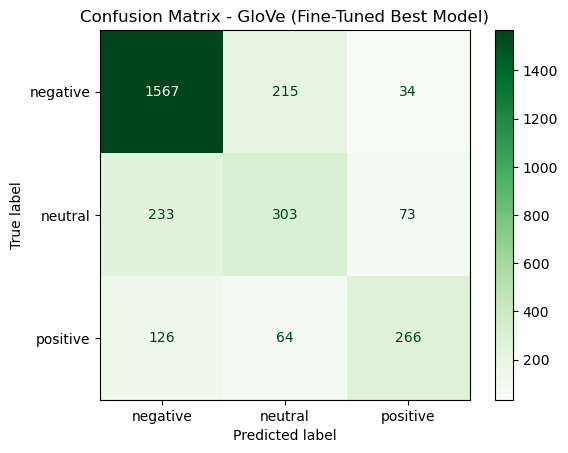

In [127]:
cm = confusion_matrix(y_test_2, y_pred_glove, labels = best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
disp.plot(cmap = 'Greens', values_format = 'd')

plt.title("Confusion Matrix - GloVe (Fine-Tuned Best Model)")
plt.show()

#### **SUMMARY**

> Based on both accuracy and F1-score, the best-performing model is Model 9 (GloVe with fine-tuning, without SMOTE), achieving 74% accuracy and a macro F1 of 0.73.  
> This strong performance is likely due to the use of a pretrained GloVe model trained on Twitter data, which aligns well with the linguistic style and structure of the dataset, also composed of tweets.  
> Another observation is that while SMOTE generally helps other models by balancing class representation, GloVe performs well even without it.  
> This suggests that GloVe’s global co-occurrence embeddings already capture the underlying relationships between words across classes, reducing the need for additional balancing.  
> However, for other representations such as BOW or TF-IDF, SMOTE remains beneficial to improve model fairness and recall for minority sentiments.